# Import Packages

In [1]:
import sys,os,pdb,glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import linmix
from scipy import stats

# Define Functions

In [2]:
def plot_linmix(ax, ax_all, a, b, c):

    """
    PURPOSE:    Plot the fit from calc_linmix()

    INPUT:      ax = matplotlib axis for this region
                ax_all = matplotlib axis for all the regions
                a, b, c = fit parameters from calc_linmix() (floats)

    OUTPUT:     none

    """

    xfit = np.log10(np.arange(10, 3e4) / 1e3)
    yfit = a + b * xfit
    ax.plot(xfit, yfit, color=c, linestyle='solid', linewidth=5, alpha=0.5, zorder=1)
    ax_all.plot(xfit, yfit, color=c, linestyle='solid', linewidth=5, alpha=0.5, zorder=1)
    

def calc_linmix(name, x, e_x, y, e_y, det):

    """
    PURPOSE:    Calculate linear regression with errors on x & y
                Uses linmix package (Python port of LINMIX_ERR IDL package)

    INPUT:      name = name of region being fit
                x, e_x = stellar mass (errors) in solar masses (float arr)
                y, e_y = dust mass (errors) in earth masses (float arr)
                det = continuum detection flag; detections d=1, non-detections d=0 (int arr)

    OUTPUT:     Linear regression fit parameters + errors

    """

    y[det == 0] = 3.0 * e_y[det == 0]
    xlog = np.log10(x)
    ylog = np.log10(y)
    e_xlog = 0.434 * (e_x / x)
    e_ylog = 0.434 * (e_y / y)

    delta = det == 1
    lmcens  = linmix.LinMix(xlog, ylog, e_xlog, e_ylog, delta=delta, K=3)
    lmcens.run_mcmc(silent=True)
    
    A, Ae = np.mean(lmcens.chain['alpha']), np.std(lmcens.chain['alpha'])
    B, Be = np.mean(lmcens.chain['beta']), np.std(lmcens.chain['beta'])
    C, Ce = np.mean(lmcens.chain['corr']), np.std(lmcens.chain['corr'])
    D, De = np.mean(np.sqrt(lmcens.chain['sigsqr'])), np.std(np.sqrt(lmcens.chain['sigsqr']))

    print( "\n>>> " + name)
    print( "    A  = {0:.2f}".format(A) + " +/- {0:.2f}".format(Ae))
    print( "    B  = {0:.2f}".format(B) + " +/- {0:.2f}".format(Be))
    print( "    C  = {0:.2f}".format(C) + " +/- {0:.2f}".format(Ce))
    print( "    D  = {0:.2f}".format(D) + " +/- {0:.2f}".format(De))

    return A, Ae, C, Ce, B, Be, D, De


def plot_region(ax, x, y, e_x, e_y, d, c):

    """
    PURPOSE:    Plot Mdust vs. Mstar for a SFR

    INPUT:      x, e_x = stellar mass (errors) in solar masses (float arr)
                y, e_y = dust mass (errors) in earth masses (float arr)
                d = continuum detection flag; detections d=1, non-detections d=0 (int arr)
                c = color for plotting (str)

    OUTPUT:     none

    """

    y[d==0] = 3.0 * e_y[d==0]
    xlog = np.log10(x)
    ylog = np.log10(y)
    e_xlog = 0.434 * (e_x / x)

    ax.scatter(xlog[d==0], ylog[d==0], marker='v', edgecolor='gray', facecolor='lightgray',s=20, linewidth=0.5, zorder=99)
    ax.scatter(xlog[d==1], ylog[d==1], marker='o', facecolor=c,s=20, linewidth=0.5, zorder=100, edgecolor='black')
    ax.errorbar(xlog[d==1], ylog[d==1], yerr=0, xerr=e_xlog[d==1], fmt='o', ms=0,ecolor='lightgray', zorder=90, linewidth=0.5)


def assign_lupus_mstar(ms, e_ms):

    """
    PURPOSE:    Assign stellar masses to Lupus targets with unknown values
                by randomly picking from distribution in Mortier+2011
                and assuming 20% error

    INPUT:      ms = stellar masses with unknowns masked (masked float arr)
                e_ms = errors on stellar masses (float arr)

    OUTPUT:     input arrays with missing stellar masses now filled in

    """

    ### INDEX STARS WITHOUT MASS MEASUREMENTS
    f_ms = np.copy(ms.mask)
    ind_nomass = np.where(ms.mask == True)

    ### DISTRIBUTION OF LUPUS STELLAR MASSES
    ### FROM Mortier+2011 (2011MNRAS.418.1194M) FIGURE 9
    hist_values = np.array([ 5., 5., 12., 12., 12., 9., 9., 9., 1., 1., 1., 1., 1., 1.])
    log_mstar_bins = np.array([-1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, 
                               -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,  0.25])
    
    ### RANDOMLY ASSIGN VALUE FROM RANGE SEEN IN LUPUS (MORTIER+2011)
    ### USE MEDIAN FRACTIONAL ERROR OF MSTAR FOR LUPUS SOURCES WITH KNOWN MSTAR 
    mstar_probs = hist_values / np.sum(hist_values)
    randm = 10**(np.random.choice(log_mstar_bins, len(ind_nomass[0]), p=list(mstar_probs)))
    for i, val in enumerate(ind_nomass[0]):
        ms[val] = "{0:.2f}".format(randm[i])
        e_ms[val] = "{0:.2f}".format(randm[i] * .20) 

    return ms, e_ms


def stack_nd(name, ax, mstar, mdust, e_mstar, e_mdust, det):

    ### CHECK STACKING NON-DETECIONS
    ### THIS IS ONLY FOR MSTAR > 0.1 SO WON'T MATCH VALUES IN PAPER
    print( "\n Stacking {0:0.0f} non-detections for ".format(len(det[det == 0])) + name)
    td, e_td = meanerr(mdust[det == 0], e_mdust[det == 0])
    print( "   ND stack signal = {0:0.2f} +/- {1:0.2f} ({2:0.2f}) sigma\n".format(td, e_td, td / e_td))
     
    ### CONVERT TO LOG
    xlog = np.log10(mstar)
    e_xlog = 0.434 * (e_mstar / mstar)

    ### CALCULATING BINNED STACKS FOR PAPER
    bin_edges = np.array([-1.0,-0.8,-0.6,-0.4,-0.2,-0.0])
    bin_edges = np.array([-1.2,-0.8,-0.4,0.0])
    for i in range(0,len(bin_edges)-1):

        ind = np.where( (xlog >= bin_edges[i]) &
                        (xlog <  bin_edges[i + 1]) &
                        (det == 0) )

        md, e_md = meanerr(mdust[ind], e_mdust[ind])
        ms, e_ms = np.mean(xlog[ind]), np.std(e_xlog[ind])

        if (md / e_md < 3.0):
            ax.plot(ms, np.log10(3.0 * e_md), 'v', color='black', zorder=100)
        else:
            ax.plot(ms,np.log10(md),'o',color='black',zorder=100)


def meanerr(val, err):

    ### CALCULATE MEAN & STANDARD ERROR ON THE MEAN
    weight = 1.0 / (err**2)
    wsum   = np.sum(weight)
    sumx   = np.sum(weight*val)
    xmean  = sumx / wsum
    sigmam = np.sqrt(1.0 / wsum)
    
    return xmean, sigmam

# Code


>>> sigma Orionis
    A  = 1.00 +/- 0.15
    B  = 1.94 +/- 0.36
    C  = 0.68 +/- 0.08
    D  = 0.62 +/- 0.09

>>> Taurus
    A  = 1.21 +/- 0.09
    B  = 1.77 +/- 0.20
    C  = 0.67 +/- 0.06
    D  = 0.61 +/- 0.05

>>> Cham I
    A  = 0.99 +/- 0.14
    B  = 1.82 +/- 0.25
    C  = 0.65 +/- 0.07
    D  = 0.78 +/- 0.08

>>> Upper Sco
    A  = 0.79 +/- 0.21
    B  = 2.41 +/- 0.37
    C  = 0.64 +/- 0.08
    D  = 0.71 +/- 0.08

 Stacking 49 non-detections for sigma Orionis
   ND stack signal = 1.86 +/- 0.09 (20.97) sigma



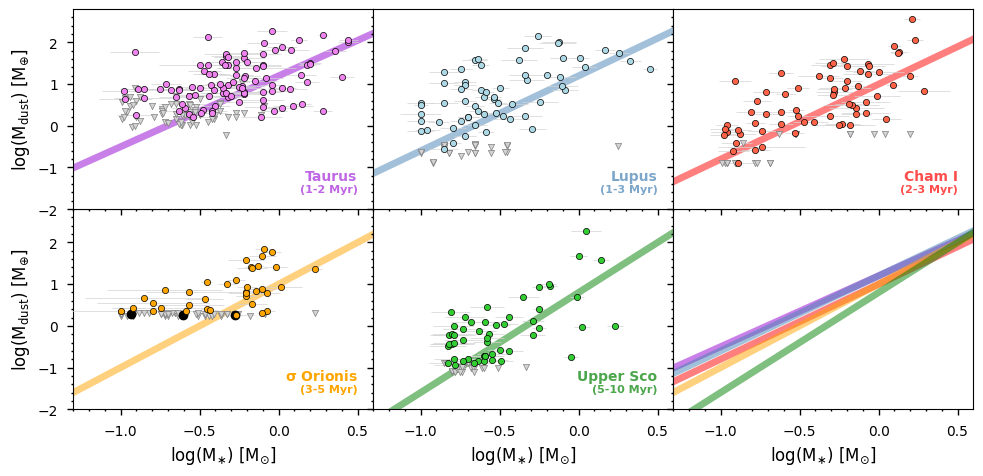

In [3]:
if __name__ == '__main__':

    ### READ IN DATA ON EACH REGION
    tau = Table.read('../output/data_tau.txt', format='ascii.ipac')
    lup = Table.read('../output/data_lup.txt', format='ascii.ipac')
    cha = Table.read('../output/data_cha.txt', format='ascii.ipac')
    sor = Table.read('../output/data_sor.txt', format='ascii.ipac')
    usc = Table.read('../output/data_usc.txt', format='ascii.ipac')

    ### GET LUPUS UNKNOWN STELLAR MASSES
    mstar, e_mstar = assign_lupus_mstar(lup['Mstar'], lup['e_Mstar'])
    lup['Mstar'], lup['e_Mstar'] = mstar, e_mstar

    ### CALCULATE LINMIX
    ### DO NOT DO LUPUS; GRAB FROM ANSDELL+2016
    sor_fit = calc_linmix('sigma Orionis', sor['Mstar'].data, sor['e_Mstar'].data, sor['MDust'].data, sor['e_MDust'].data, sor['Det'].data)
    tau_fit = calc_linmix('Taurus', tau['Mstar'].data, tau['e_Mstar'].data, tau['MDust'].data, tau['e_MDust'].data, tau['Det'].data)    
    cha_fit = calc_linmix('Cham I', cha['Mstar'].data, cha['e_Mstar'].data, cha['MDust'].data, cha['e_MDust'].data, cha['Det'].data)
    usc_fit = calc_linmix('Upper Sco', usc['Mstar'].data, usc['e_Mstar'].data, usc['MDust'].data, usc['e_MDust'].data, usc['Det'].data)

    ### MAKE PLOT
    plt.close('all')
    fig = plt.figure(figsize=(12, 5))
    xmin, xmax, ymin, ymax = -1.3, 0.6, -2.0, 2.8
    mpl.rc('xtick.major', size=4, pad=7, width=1)
    mpl.rc('ytick.major', size=4, pad=7, width=1)
    mpl.rc('xtick.minor', size=1.5, pad=7, width=1)
    mpl.rc('ytick.minor', size=1.5, pad=7, width=1)

    ### CREATE SHARED AXES
    ax_sor = fig.add_axes([0.05, 0.05, 0.25, 0.40])
    ax_tau = fig.add_axes([0.05, 0.45, 0.25, 0.40])
    ax_usc = fig.add_axes([0.30, 0.05, 0.25, 0.40])
    ax_lup = fig.add_axes([0.30, 0.45, 0.25, 0.40])
    ax_all = fig.add_axes([0.55, 0.05, 0.25, 0.40])
    ax_cha = fig.add_axes([0.55, 0.45, 0.25, 0.40])

    ### FIX TICKMARKS AND LABELS
    ax_tau.tick_params(which='both',top=False,right=False,labelbottom=False,labelsize=10)
    ax_lup.tick_params(which='both',top=False,right=False,labelbottom=False,labelleft=False)
    ax_cha.tick_params(which='both',top=False,right=False,labelbottom=False,labelleft=False)
    ax_sor.tick_params(which='both',top=False,right=False,labelsize=10)
    ax_usc.tick_params(which='both',top=False,right=False,labelleft=False,labelsize=10)
    ax_all.tick_params(which='both',top=False,right=False,labelleft=False,labelsize=10)

    ### PLOT REGION NAMES
    ax_tau.text(0.5,-1.3,'Taurus',size=10,color='darkviolet',fontweight='bold',ha='right',alpha=0.6)
    ax_tau.text(0.5,-1.6,'(1-2 Myr)',size=8,color='darkviolet',fontweight='bold',ha='right',alpha=0.6)
    ax_lup.text(0.5,-1.3,'Lupus',size=10,color='steelblue',fontweight='bold',ha='right',alpha=0.7)
    ax_lup.text(0.5,-1.6,'(1-3 Myr)',size=8,color='steelblue',fontweight='bold',ha='right',alpha=0.7)
    ax_cha.text(0.5,-1.3,'Cham I',size=10,color='red',fontweight='bold',ha='right',alpha=0.7)
    ax_cha.text(0.5,-1.6,'(2-3 Myr)',size=8,color='red',fontweight='bold',ha='right',alpha=0.7)
    ax_sor.text(0.5,-1.3,r'$\mathregular{\sigma}$'+' Orionis',size=10,color='orange',fontweight='bold',ha='right')
    ax_sor.text(0.5,-1.6,'(3-5 Myr)',size=8,color='orange',fontweight='bold',ha='right')
    ax_usc.text(0.5,-1.3,'Upper Sco',size=10,color='green',fontweight='bold',ha='right',alpha=0.7)
    ax_usc.text(0.5,-1.6,'(5-10 Myr)',size=8,color='green',fontweight='bold',ha='right',alpha=0.7)

    ### SET AXES
    ax = np.array([ax_tau, ax_lup, ax_cha, ax_sor, ax_usc, ax_all])
    for i,val in enumerate(ax):
        ax[i].set_xlim([xmin,xmax])
        ax[i].set_ylim([ymin,ymax])
        ax[i].minorticks_on()
        if ( (i == 0) | (i==3) ):
            ax[i].set_ylabel(r'$\mathregular{log(M_{dust})}$'+' '+r'$\mathregular{[M_{\oplus}]}$',fontsize=12)
        if (i >=3):
            ax[i].set_xlabel(r'$\mathregular{log(M_{\ast})}$'+' '+r'$\mathregular{[M_{\odot}]}$',fontsize=12)

    ### PLOT STACKED NON-DETECTIONS
    stack_nd('sigma Orionis', ax_sor, sor['Mstar'].data, sor['MDust'].data, sor['e_Mstar'].data, sor['e_MDust'].data, sor['Det'].data)

    ### PLOT DISKS
    plot_region(ax_sor, sor['Mstar'].data, sor['MDust'].data, sor['e_Mstar'].data, sor['e_MDust'].data, sor['Det'].data, 'orange')
    plot_region(ax_lup, lup['Mstar'].data, lup['MDust'].data, lup['e_Mstar'].data, lup['e_MDust'].data, lup['Det'].data, 'lightblue')
    plot_region(ax_usc, usc['Mstar'].data, usc['MDust'].data, usc['e_Mstar'].data, usc['e_MDust'].data, usc['Det'].data, 'limegreen')
    plot_region(ax_cha, cha['Mstar'].data, cha['MDust'].data, cha['e_Mstar'].data, cha['e_MDust'].data, cha['Det'].data, 'tomato')
    plot_region(ax_tau, tau['Mstar'].data, tau['MDust'].data, tau['e_Mstar'].data, tau['e_MDust'].data, tau['Det'].data, 'violet')

    ### PLOT LINMIX FITS
    plot_linmix(ax_tau, ax_all, 1.2, 1.7, 'darkviolet')
    plot_linmix(ax_lup, ax_all, 1.2, 1.8, 'steelblue')
    plot_linmix(ax_cha, ax_all, 1.0, 1.8, 'red')
    plot_linmix(ax_sor, ax_all, 1.0, 2.0, 'orange')
    plot_linmix(ax_usc, ax_all, 0.8, 2.4, 'green')

    ### SAVE PLOT
    fig.savefig('../output/figure_07.png',bbox_inches='tight',dpi=900)